In [65]:
file_path = '/Users/Pato/Dev/Data_Templates/data/clean_data.csv'


In [66]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

data = pd.read_csv(file_path)


In [67]:
data= data.drop(columns=['brand','model','body_type'])


In [68]:
X = data.drop(columns=['price'])
y = data['price']

In [69]:
from sklearn.model_selection import train_test_split

# Split the data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [70]:
from sklearn.linear_model import LinearRegression

# Initialize the model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)


LinearRegression()

In [72]:
from sklearn.metrics import mean_squared_error, r2_score

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Mean Squared Error: 3185033.958758638
R-squared: 0.8157874833816778


In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

def regression_diagnostics(X, y):
    # Convert all columns in X to numeric, coercing errors to NaN
    X = X.apply(pd.to_numeric, errors='coerce')
    
    # Convert boolean columns to integers (True -> 1, False -> 0)
    X = X.astype({col: 'int' for col in X.select_dtypes(include='bool').columns})

    # Convert target variable y to numeric
    y = pd.to_numeric(y, errors='coerce')

    # Replace inf and -inf with NaN, then fill NaNs with zeroes
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    y.replace([np.inf, -np.inf], np.nan, inplace=True)
    X.fillna(0, inplace=True)
    y.fillna(0, inplace=True)

    # Ensure X and y are purely numeric
    X = X.to_numpy(dtype=np.float64)
    y = y.to_numpy(dtype=np.float64)

    # Add constant to X for intercept
    X = sm.add_constant(X)

    # Fit the linear model
    model = sm.OLS(y, X).fit()

    # Extract and print model details
    coefficients = model.params
    r_squared = model.rsquared
    adjusted_r_squared = model.rsquared_adj
    p_values = model.pvalues
    residual_standard_error = np.sqrt(model.mse_resid)
    mse = mean_squared_error(y, model.fittedvalues)

    print("Coefficients:\n", coefficients)
    print("\nR-squared:", r_squared)
    print("\nAdjusted R-squared:", adjusted_r_squared)
    print("\nP-values:\n", p_values)
    print("\nResidual Standard Error:", residual_standard_error)
    print("\nMean Squared Error:", mse)

    # Create a more visually appealing set of diagnostic plots
    sns.set(style="whitegrid")
    plt.figure(figsize=(16, 12))

    # Residuals vs Fitted plot
    plt.subplot(2, 2, 1)
    sns.residplot(x=model.fittedvalues, y=model.resid, lowess=True, scatter_kws={'alpha':0.7}, line_kws={'color': 'red', 'lw': 2})
    plt.xlabel('Fitted values', fontsize=12)
    plt.ylabel('Residuals', fontsize=12)
    plt.title('Residuals vs Fitted', fontsize=14)

    # Q-Q plot
    plt.subplot(2, 2, 2)
    sm.qqplot(model.resid, line='45', fit=True, ax=plt.gca())
    plt.title('Normal Q-Q', fontsize=14)

    # Scale-Location plot (Spread vs Fitted)
    plt.subplot(2, 2, 3)
    standardized_residuals = model.resid / np.std(model.resid)
    plt.scatter(model.fittedvalues, np.sqrt(np.abs(standardized_residuals)), alpha=0.7)
    plt.axhline(y=0, color='red', linestyle='--', lw=2)
    plt.xlabel('Fitted values', fontsize=12)
    plt.ylabel('Sqrt(|Standardized Residuals|)', fontsize=12)
    plt.title('Scale-Location', fontsize=14)

    # Residuals vs Leverage
    plt.subplot(2, 2, 4)
    sm.graphics.influence_plot(model, criterion="cooks", ax=plt.gca(), size=8, alpha=0.7)
    plt.title('Residuals vs Leverage', fontsize=14)

    plt.tight_layout()
    plt.show()

# Note: Replace X and y with actual data before running this function.
# regression_diagnostics(X, y)


Coefficients:
 [-2.60523723e-01 -3.12548963e-02  1.28042320e+01 -7.22328729e+01
 -1.40844973e+02 -3.57720875e+01 -1.02493383e+02 -5.39843723e+02
 -4.01131705e+03 -5.98188347e+03 -1.97257612e+03  4.79449054e+02
 -2.11454880e+03  8.20545944e+03 -2.69677021e+03 -2.64520579e+02
 -9.73267349e+01  5.64649967e+03 -4.01020454e+03 -6.52971250e+03
 -7.77005108e+03 -8.53501534e+03 -6.52491429e+03 -8.46502789e+03]

R-squared: 0.8238047065822566

Adjusted R-squared: 0.8227201244739213

P-values:
 [1.61418100e-201 1.87868984e-158 4.90829272e-119 3.76927299e-005
 2.87960479e-002 3.21972581e-001 9.31014180e-002 1.89587154e-205
 1.31292585e-005 2.06296408e-002 1.04187403e-042 5.24815106e-008
 1.83458836e-128 8.35816515e-006 5.79515296e-009 5.00501358e-004
 7.31968539e-001 1.45134952e-049 5.90963845e-005 6.38100241e-012
 3.60215785e-016 1.99836921e-018 6.93927342e-011 4.75790503e-017]

Residual Standard Error: 1833.8927346873481

Mean Squared Error: 3341657.769752496


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:847: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy shou

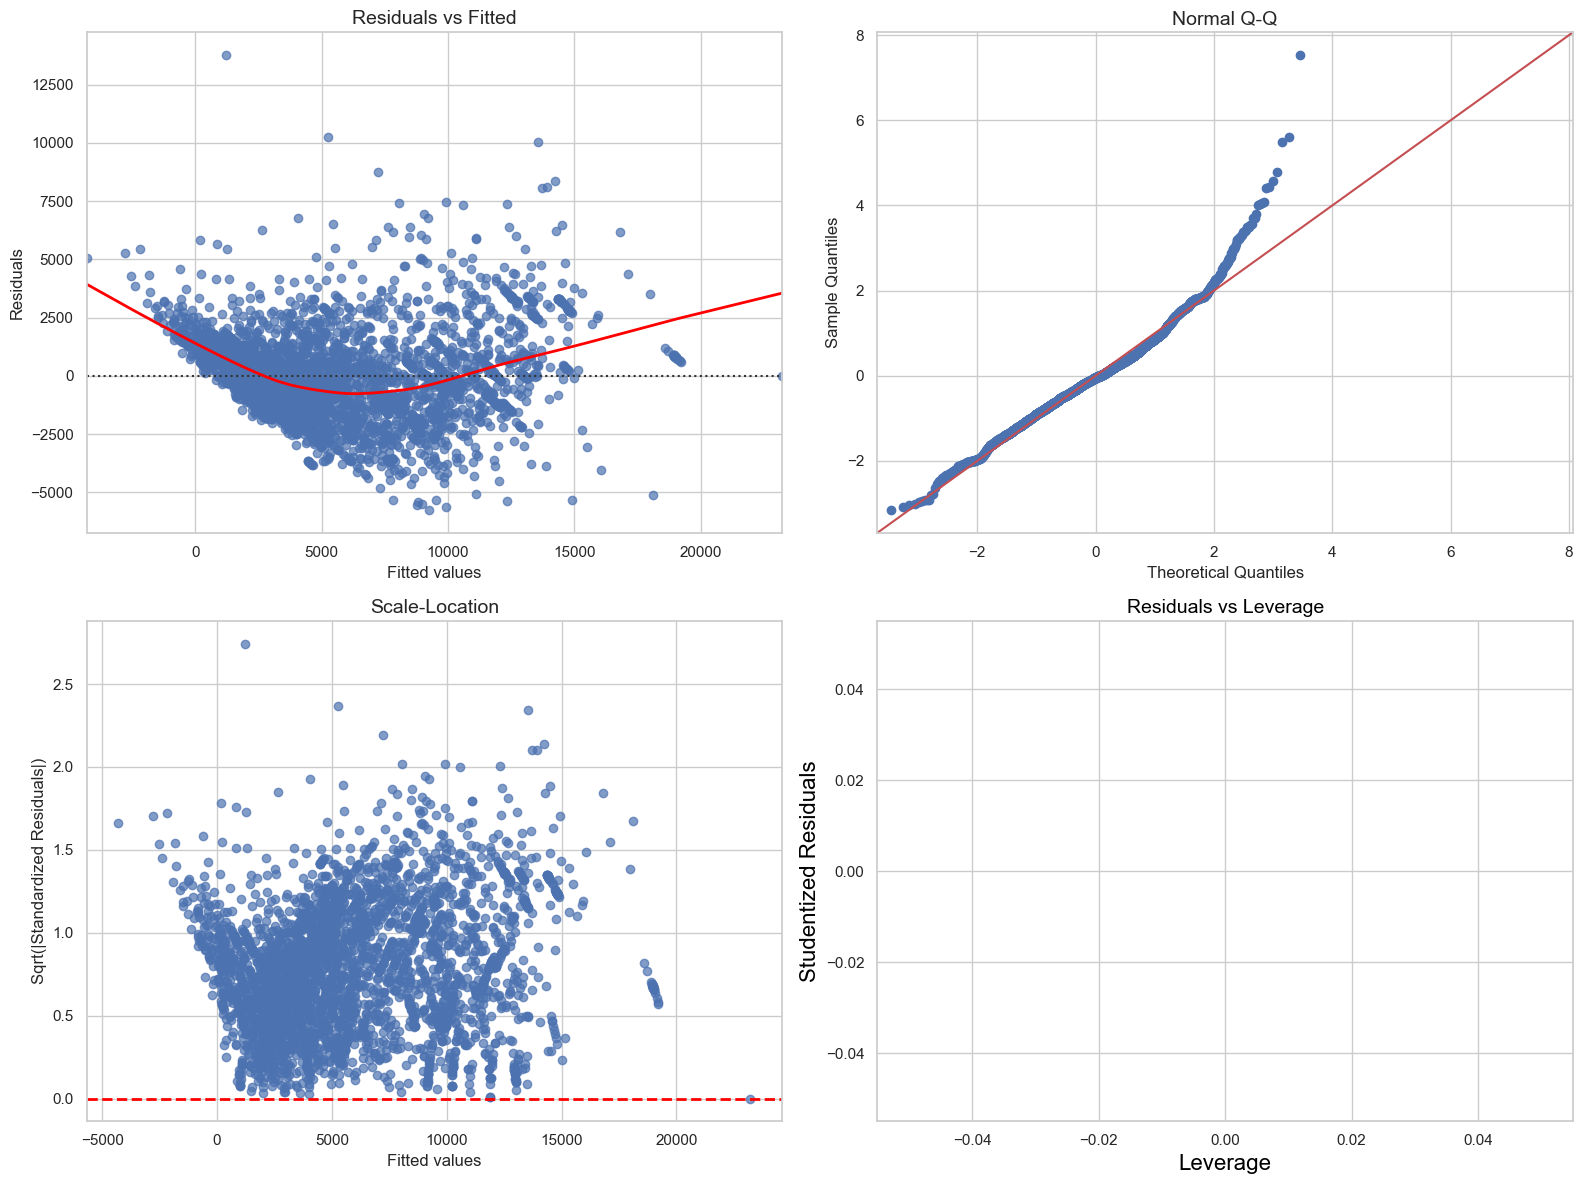

In [75]:
regression_diagnostics(X,y)

In [81]:
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

def evaluate_single_variable_models(data, target_column):
    # Ensure all columns are converted to numeric, coercing errors to NaN
    data = data.apply(lambda col: pd.to_numeric(col, errors='coerce'))
    
    # Drop rows with any NaN values after conversion
    data = data.dropna()

    # Check if all remaining columns are numeric
    if not all(data.dtypes.apply(lambda x: np.issubdtype(x, np.number))):
        raise ValueError("Data contains non-numeric columns even after conversion.")

    # Store performance metrics
    performance_metrics = []

    # Iterate over each column in the data except the target
    for col in data.columns:
        if col == target_column:
            continue

        # Prepare the independent variable (X) and dependent variable (y)
        X = data[[col]]  # Single predictor
        y = data[target_column]

        # Add a constant to the model for the intercept
        X = sm.add_constant(X)

        # Fit the model
        try:
            model = sm.OLS(y, X).fit()
        except Exception as e:
            print(f"Failed to fit model with {col}: {e}")
            continue

        # Calculate performance metrics
        r_squared = model.rsquared
        adj_r_squared = model.rsquared_adj
        mse = mean_squared_error(y, model.fittedvalues)

        # Append results to the list
        performance_metrics.append({
            'Variable': col,
            'R-squared': r_squared,
            'Adjusted R-squared': adj_r_squared,
            'MSE': mse
        })

    # Convert the results to a DataFrame for easy viewing
    performance_df = pd.DataFrame(performance_metrics)
    return performance_df

# Example usage
# Assuming 'data' is your DataFrame and 'price' is your target variable
# Replace 'price' with your actual target variable name
# performance_results = evaluate_single_variable_models(data, 'price')

# Display the performance results sorted by R-squared
# performance_results.sort_values(by='R-squared', ascending=False)


In [82]:
evaluate_single_variable_models(data,"price")

ValueError: Data contains non-numeric columns even after conversion.